# Example: Gaussian with Given Variance

As a model we are given a univariate Gaussian distribution with unknown mean
and standard deviation ``\sigma = 1``. We have one data point at 2.0. For this
toy example, we can compute the posterior over the mean. But to illustrate
likelihood-free inference, let us assume here that we can only sample from the
model:

In [1]:
using LikelihoodfreeInference, Distributions, Random
model(x) = randn() .+ x

model (generic function with 1 method)

LikelihoodfreeInference.jl passes parameter values as vectors to the model,
even in the one-dimensional case. In our definition of the model we assume
that `x[1]` is the mean.

## Approximate the Posterior
Our first goal is to find the posterior over the mean given observation and
a Gaussian prior with mean 0 and standard deviation 5.

In [2]:
data = [2.0]
prior = MultivariateNormal([0.], [5.])

DiagNormal(
dim: 1
μ: [0.0]
Σ: [25.0]
)


The true posterior is a Gaussian distribution with mean 25/26*2 and standard
deviation 26/25

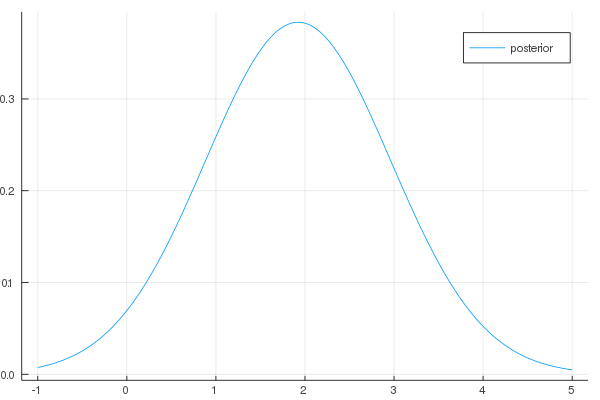

In [3]:
trueposterior = pdf.(Normal.(-1:.01:5, 26/25), 25/26*2.0)
using Plots
figure = Plots.plot(-1:.01:5, trueposterior, label = "posterior")

Now, we will use an adaptive sequential Monte Carlo method:

In [4]:
smc = AdaptiveSMC(prior = prior, K = 10^4)
result = run!(smc, model, data, verbose = true, maxfevals = 10^6);

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1     2 seconds    19000 9.126882e+00 0.8999999999999997
         2     3 seconds    27101 7.283661e+00 0.8101000000000007
         3     4 seconds    34392 6.103246e+00 0.7291000000000007
         4     5 seconds    40954 5.247264e+00 0.6561999999999998
         5     6 seconds    46860 4.535923e+00   0.5906
         6     7 seconds    52176 3.996735e+00   0.5316
Resampling...
         7     8 seconds    62176 3.552890e+00 0.9999999999999998
         8     9 seconds    71176 3.165294e+00 0.8999999999999997
         9    10 seconds    79277 2.823163e+00 0.8101000000000007
        10    11 seconds    86568 2.517832e+00 0.7291000000000006
        11    12 seconds    93130 2.260144e+00 0.6561999999999996
        12    13 seconds    99036 2.019568e+00 0.5906000000000001
        13    14 seconds   104352 1.803596e+00   0.5316
Resampling...
        14    15 seconds   114352 1.6116

As a Monte Carlo Method the result is a list of particles

In [5]:
particles(smc)

10000-element Array{Array{Float64,1},1}:
 [1.8792267902792215]
 [2.631787181304744] 
 [2.3242719309101094]
 [2.7682475963763395]
 [1.9480707964802482]
 [2.5607965729467286]
 [3.1965074924107455]
 [2.2146429321285837]
 [1.3851037060244915]
 [2.58295754614415]  
 ⋮                   
 [1.921170712287424] 
 [3.0249754711943453]
 [3.3278101596824996]
 [1.1729037620028264]
 [2.5676241363010472]
 [1.0521036506202732]
 [3.1061462485909983]
 [1.8276268282781962]
 [1.8798757413674434]

with corresponding weights

In [6]:
weights(smc)

10000-element Array{Float64,1}:
 0.0                   
 0.0                   
 0.00017328019407381737
 0.00017328019407381737
 0.00017328019407381737
 0.0                   
 0.00017328019407381737
 0.0                   
 0.0                   
 0.0                   
 ⋮                     
 0.0                   
 0.00017328019407381737
 0.00017328019407381737
 0.00017328019407381737
 0.00017328019407381737
 0.0                   
 0.00017328019407381737
 0.00017328019407381737
 0.00017328019407381737

The mean of the posterior is given by `weights(smc) .* particles(smc)`, which
is computed by the `mean` function.

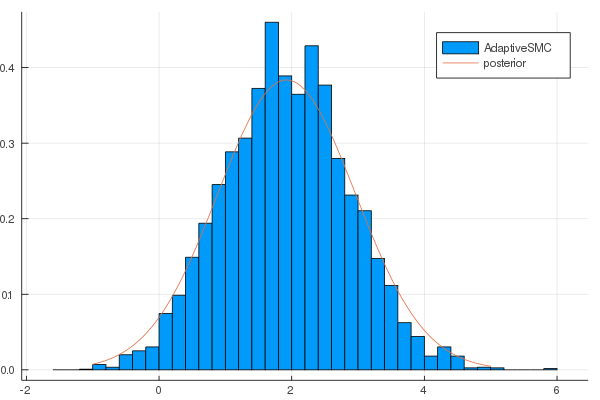

In [7]:
mean(smc)

figure = histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

The `result` above also contains these weights and particles and some
additional information.

In [8]:
keys(result)

(:weights, :particles, :n_sims, :epsilons)

AdaptiveSMC reduced the epsilon parameter adaptively, as we saw in column
epsilon of the run above. We can plot this sequence.

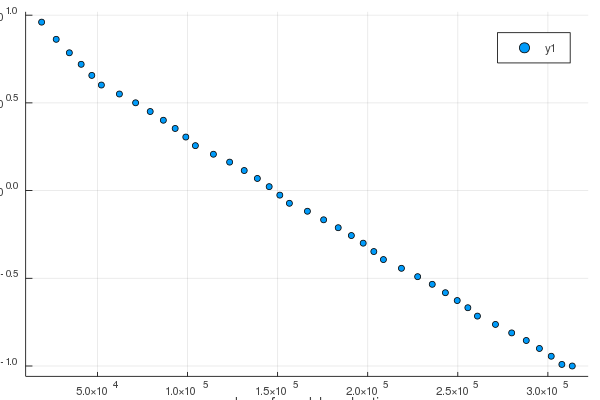

In [9]:
Plots.scatter(cumsum(result.n_sims)[2:end], result.epsilons,
              yscale = :log10, ylabel = "epsilon", xlabel = "number of model evaluations")

Alternatively, we may want to use KernelABC.

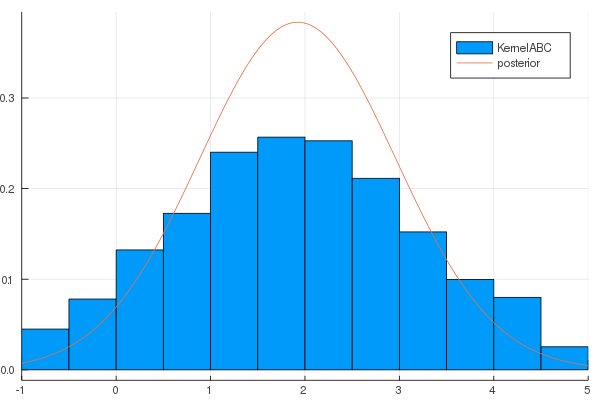

In [10]:
kabc = KernelABC(prior = prior,
                 kernel = Kernel(),
                 delta = 1e-8,
                 K = 10^4)
result = run!(kabc, model, data, maxfevals = 10^4)
mean(kabc)

figure = histogram(vcat(particles(kabc)...), weights = weights(kabc),
                   xlims = (-1, 5), bins = 100,
                   normalize = true, label = "KernelABC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

## Point Estimates
Sometimes we just want a point estimate. We will use BayesianOptimization.jl
here to minimize the default `QDLoss`. We know that the true maximum
likelihood estimate is at mean = 25/26*2 ≈ 1.923

In [11]:
using BayesianOptimization
p = PointEstimator(optimizer = bo([-10.], [10.]), prior = prior, K = 100)
result = run!(p, model, data, maxfevals = 5*10^4, verbose = false);
result.x

1-element Array{Float64,1}:
 1.8644239521649832

KernelRecursiveABC is an alternative method that requires often only few model
evaluations in low and medium dimensional problems

In [12]:
k = KernelRecursiveABC(prior = prior,
                       kernel = Kernel(),
                       kernelx = Kernel(),
                       delta = 1e-2,
                       K = 100)
result = run!(k, model, data, maxfevals = 2*10^3)
result.x

iteration         elapsed     fevals
        1       0 seconds        100
        2        1 second        200
        3       2 seconds        300
        4       3 seconds        400
        5       3 seconds        500
        6       4 seconds        600
        7       4 seconds        700
        8       5 seconds        800
        9       5 seconds        900
       10       6 seconds       1000
       11       7 seconds       1100
       12       7 seconds       1200
       13       8 seconds       1300
       14       8 seconds       1400
       15       9 seconds       1500
       16       9 seconds       1600
       17      10 seconds       1700
       18      10 seconds       1800
       19      11 seconds       1900
       20      12 seconds       2000


1-element Array{Float64,1}:
 2.06855328806251

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*